In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

## Importing the Time Series 

In [2]:
data = pd.read_csv("../input/time-series-datasets/monthly-beer-production-in-austr.csv", index_col='Month', parse_dates=True)
data.columns = ["Production"]
print(data.shape)

(476, 1)


In [3]:
data.head()

,Production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [4]:
data.tail()

,Production
Month,
1995-04-01,127.0
1995-05-01,151.0
1995-06-01,130.0
1995-07-01,119.0
1995-08-01,153.0


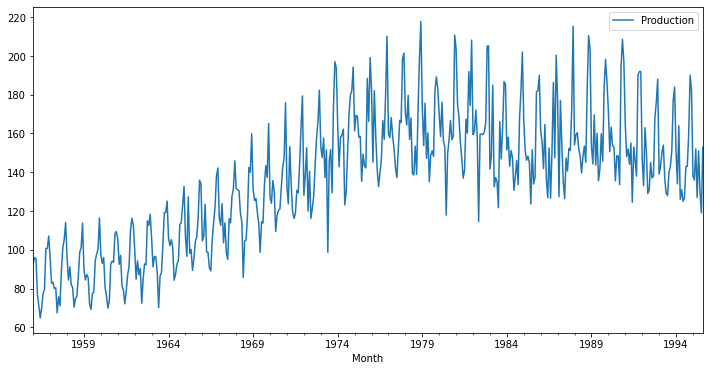

In [5]:
data.plot(figsize=(12,6))
plt.show()

## Visualizing components of the series 

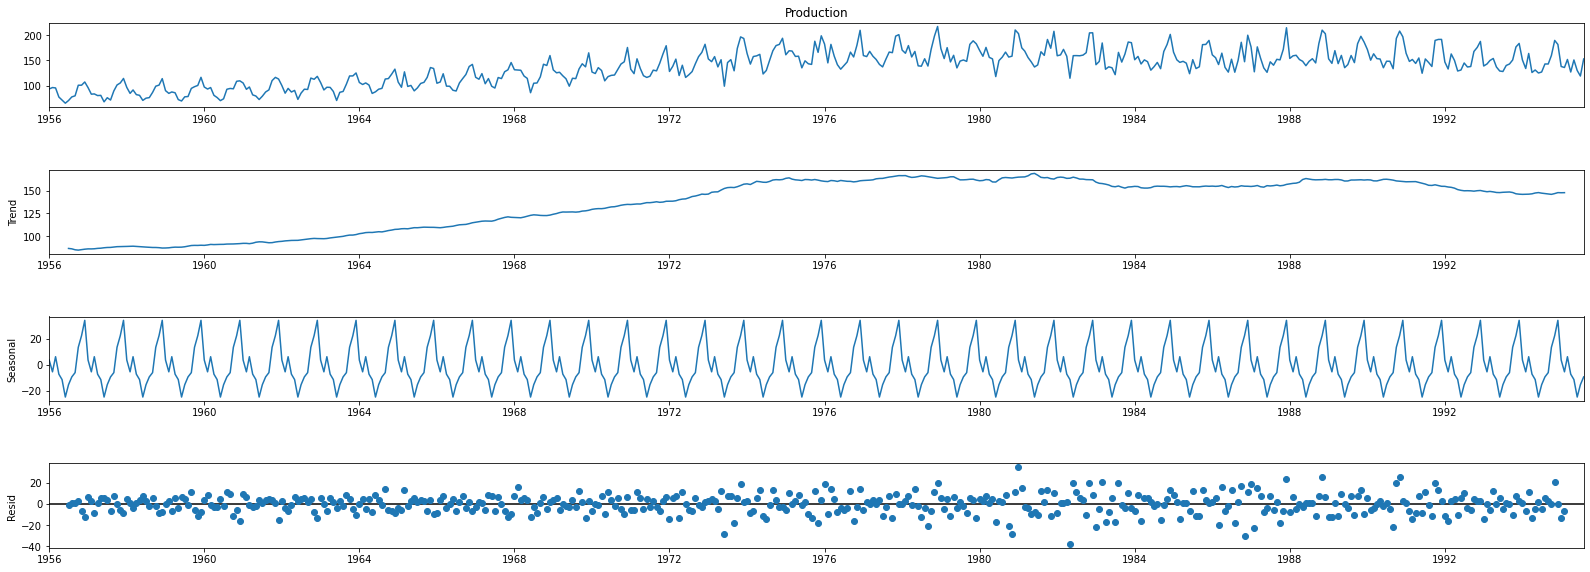

In [6]:
decomposed = seasonal_decompose(data['Production'])
fig = decomposed.plot()
fig.set_size_inches((25,9))
fig.show()

We can see a seasonal pattern throughout the series, but there's no trend after 1975.

## Preparing the series

In [7]:
train = data[:'1992-12-31']
test = data['1993-01-01':]

In [8]:
print("Shape of training set: ", train.shape)
print("Shape of testing set: ", test.shape)

Shape of training set:  (444, 1)
Shape of testing set:  (32, 1)


In [9]:
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler()

In [10]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [11]:
n_months = 12
generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(scaled_train, scaled_train, length=n_months, batch_size=1)

## LSTM Model

In [12]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_months, 1)),
    tf.keras.layers.LSTM(100, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(50, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(25, activation='tanh'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

2022-09-21 11:47:37.107212: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 100)           40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 50)            30200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense (Dense)                (None, 1)                 26        
Total params: 78,626
Trainable params: 78,626
Non-trainable params: 0
_________________________________________________________________


In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", verbose=1, patience=2)
history = model.fit(generator, epochs=10, callbacks=[early_stop])

Epoch 1/10


2022-09-21 11:47:37.973353: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


432/432 [==============================] - 13s 16ms/step - loss: 0.0243
Epoch 2/10
432/432 [==============================] - 7s 15ms/step - loss: 0.0170
Epoch 3/10
432/432 [==============================] - 7s 15ms/step - loss: 0.0150
Epoch 4/10
432/432 [==============================] - 7s 17ms/step - loss: 0.0118
Epoch 5/10
432/432 [==============================] - 7s 16ms/step - loss: 0.0103
Epoch 6/10
432/432 [==============================] - 7s 16ms/step - loss: 0.0098
Epoch 7/10
432/432 [==============================] - 7s 17ms/step - loss: 0.0090
Epoch 8/10
432/432 [==============================] - 7s 15ms/step - loss: 0.0083
Epoch 9/10
432/432 [==============================] - 7s 16ms/step - loss: 0.0088
Epoch 10/10
432/432 [==============================] - 7s 16ms/step - loss: 0.0084
Epoch 00010: early stopping


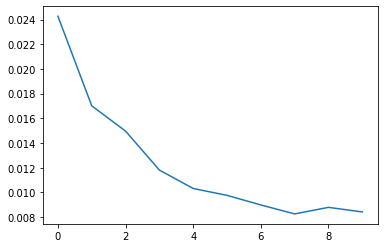

In [14]:
plt.plot(history.history['loss'])
plt.show()

## Evaluating the model 

In [15]:
temp = scaled_train[-n_months:]
temp = temp.reshape((1, n_months, 1))
model.predict(temp)

array([[0.62560856]], dtype=float32)

In [16]:
test_predictions = []
last_batch = scaled_train[-n_months:]
current_batch = last_batch.reshape((1, n_months, 1))
for i in range((test.shape[0])):
    pred = model.predict(current_batch)[0]
    test_predictions.append(pred)
    current_batch = np.append(current_batch[:, 1:, :], [[pred]], axis=1)

In [17]:
test['LSTM_predictions'] = scaler.inverse_transform(test_predictions)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


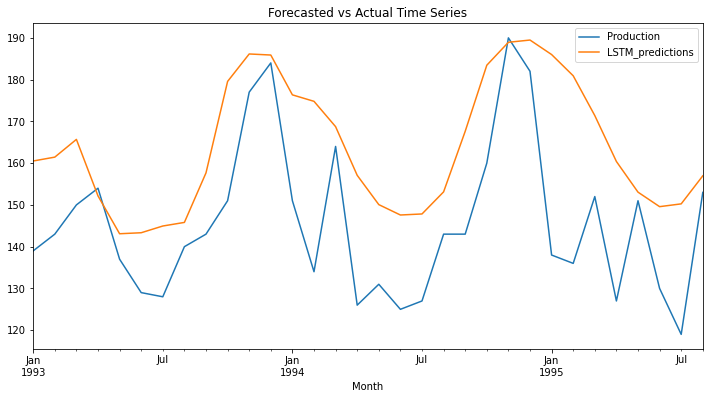

In [18]:
test.plot(figsize=(12,6))
plt.title("Forecasted vs Actual Time Series")
plt.show()